In [27]:
import sys
sys.path.append(r"C:\My Projects\Health-Navigator")

from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any

from helper_utils.clear_valid_input_validator.input_validator import validate_first_input, validate_input_text_only
from helper_utils.extract_text_from_attachments import extract_text_from_file

from app.workflow.ml_models.vision_models.input_image_classification.image_classifier import classify_image
from app.workflow.ml_models.vision_models.ocr import extract_text

from app.workflow.agents.numerical_models_agent.agent import invoke_agent as invoke_numerical_models_agent
from app.workflow.agents.vision_models_agent.agent import invoke_agent as invoke_vision_models_agent


In [28]:
class AgentState(TypedDict):
    input_prompt: str
    attachments: Dict[str, Any] # dict, each with {user naming for that attachment, the attachment path}

In [29]:
def first_input_validation_node(state: AgentState):
    input_prompt = state['input_prompt']
    attachments = list(state["attachments"].keys())

    first_input_validation_result = validate_first_input(input_prompt, attachments)
    state["input_validation_result"] = first_input_validation_result
    state["coming_from_validation"] = "first_input_text"

    return state

In [30]:
def second_input_validation_node(state: AgentState): # validate extracted text from images or attachments
    coming_from_validation = state["coming_from_extracted_text"]

    if coming_from_validation == "images":
        full_input_text = state["extracted_text_from_images"]
    elif coming_from_validation == "attachments":
        full_input_text = state["extracted_text_from_attachments"]

    full_validation_results = []

    for input_text in full_input_text:
        # result[0] = title
        # result[1] = extracted_text
        
        title = input_text[0]
        extracted_text = input_text[1]

        one_validation_results = validate_input_text_only(title, extracted_text)
        full_validation_results.append(one_validation_results)
    if state.get("extracted_text_from_images_or_attachments_validation_results") is None:
        
        state["extracted_text_from_images_or_attachments_validation_results"] = full_validation_results
    else:
        state["extracted_text_from_images_or_attachments_validation_results"].extend(full_validation_results)

    return state

In [31]:
def input_not_valid_fallback_node(state: AgentState):
    validation_results = state["input_validation_result"]

    if state["coming_from_validation"] == "first_input_text":

        if validation_results == "TEXT_VALID_ATTACHMENT_NOT_VALID": # TODO will be implemented later (return to the frontend)
            pass
        elif validation_results == "TEXT_NOT_VALID_ATTACHMENT_VALID": # TODO will be implemented later (return to the frontend)
            pass
        elif validation_results == "TEXT_NOT_VALID_ATTACHMENT_NOT_VALID": # TODO will be implemented later (return to the frontend)
            pass
    
    elif state["coming_from_validation"] == "second_input_text":
        pass # TODO will be implemented later (Not a valid extracted text eather from an image or a file) (return to the frontend)

    elif state["coming_from_validation"] == "input_image":
        pass # TODO will be implemented later (Not a valid image)
    
    return state

In [32]:
def input_image_classification_node(state: AgentState):
    input_images_titles_and_paths = state["input_images_titles_and_paths"] # should be a dictionarie with 'title' key and 'path' value for each item

    results = [] # a list of lists, each list have [title, path, classification]
    medical_images = []
    text_images = []

    for title, path in input_images_titles_and_paths.items():
        classification = classify_image(title, path)
        
        result = [title, path, classification]

        if classification == "text":
            text_images.append(result)
        
        elif classification == "not_valid_image":
            pass

        else: # medical images
            medical_images.append(result)

        results.append(result)

    if text_images:
        state["text_images"] = text_images
        
    if medical_images:
        state["medical_images"] = medical_images


    
    state["input_images_classification_results"] = results

    return state

In [33]:
def extract_text_from_images_node(state: AgentState):
    full_images_results = state["text_images"]
    full_extracted_text = []

    for image_result in full_images_results:
        
        # image_result[0] = title
        # image_result[1] = path
        # image_result[2] = classification
        title = image_result[0]
        path = image_result[1]

        extracted_text = extract_text(path)

        full_extracted_text.append([title, extracted_text])
        # result[0] = title
        # result[1] = extracted_text

    state["extracted_text_from_images"] = full_extracted_text
    state["coming_from_extracted_text"] = "images"
    return state

In [34]:
def extract_text_from_files_node(state: AgentState):

    full_files = state["input_files_titles_and_paths"]
    full_extracted_text = []

    for title, path in full_files.items():
        extracted_text = extract_text_from_file(path)

        full_extracted_text.append([title, extracted_text])

    state["extracted_text_from_attachments"] = full_extracted_text
    state["coming_from_extracted_text"] = "attachments"


    return state


In [35]:
def numerical_models_agent_node(state: AgentState):
    extracted_text = state["extracted_text_from_images_or_attachments_validation_results"] if state["extracted_text_from_images_or_attachments_validation_results"] else "No extracted text"
    input_prompt = state['input_prompt'] if state['input_prompt'] else 'No input prompt'

    full_input = f"Input Prompt: {input_prompt}\n\n Extracted Text: {extracted_text}"


    result = invoke_numerical_models_agent(user_input=full_input, user_id=state["user_id"])

    state["numerical_models_agent_output"] = result
    return state


In [36]:
def medical_vision_models_agent_node(state: AgentState):
    # very important note here: the paths of the images or anything in the workflow should contain \\ and not \
    images = state["medical_images"]
    
    results = invoke_vision_models_agent(str(images))

    state["medical_vision_models_agent_output"] = results
    
    return state

In [37]:
def models_agents_output_aggregator_node(state: AgentState):
    vision_agent_input = str(state["medical_images"]) if state.get("medical_images") else "No medical images"
    vision_agent_output = str(state["medical_vision_models_agent_output"]) if state.get("medical_vision_models_agent_output") else "No vision agent output"

    input_prompt = str(state['input_prompt']) if state['input_prompt'] else 'No input prompt'
    
    numerical_agent_input = str(state["extracted_text_from_images_or_attachments_validation_results"]) if state["extracted_text_from_images_or_attachments_validation_results"] else "No extracted text"
    numerical_agent_output = str(state["numerical_models_agent_output"]) if state.get("numerical_models_agent_output") else "No numerical agent output"

    full_aggregated_output = f"""
                Input Prompt: {input_prompt} \n\n 
                Extracted Text: {numerical_agent_input} \n\n 
                Numerical Agent input: {numerical_agent_input} \n\n 
                Numerical Agent output: {numerical_agent_output} \n\n 
                Vision Agent input: {vision_agent_input} \n\n 
                Vision Agent output: {vision_agent_output}
            """
    
    state["models_agents_aggregated_output"] = full_aggregated_output
    return state

In [38]:
def input_image_classification_route(state: AgentState):
    full_images_results = state["input_images_classification_results"]

    for image_result in full_images_results:

        # image_result[0] = title
        # image_result[1] = path
        # image_result[2] = classification

        if image_result[2] == "not_valid_image":
            state["coming_from_validation"] = "input_image"
            return ["input_not_valid_fallback_node"] # for The extract text from image node
        
    
    nodes_to_return = []
    if state["text_images"]:
        nodes_to_return.append("extract_text_from_images_node")
    
    if state["medical_images"]:
        nodes_to_return.append("medical_vision_models_agent_node")

    if state.get("input_prompt") and not state.get("text_images"):
        nodes_to_return.append("numerical_models_agent_node")

    return nodes_to_return


In [39]:
def input_splitter_route(state: AgentState):
    if state["input_validation_result"] != "TEXT_VALID_ATTACHMENT_VALID":
        return "input_not_valid_fallback_node"

    text_provided = True if state['input_prompt'] else False

    attachments_files = {}
    attachments_images = {}

    for key, value in state['attachments_and_images'].items(): # key is the title here, and value is the path
        if value.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            attachments_images[key] = value
        else:
            attachments_files[key] = value
    
    state["input_images_titles_and_paths"] = attachments_images
    state["input_files_titles_and_paths"] = attachments_files

    state["has_files"] = bool(attachments_files)


    if text_provided and attachments_files and attachments_images:
        return ["extract_text_from_files_node", "input_image_classification_node"] 

    if text_provided and attachments_files and not attachments_images:
        return ["extract_text_from_files_node"] 
    
    if text_provided and not attachments_files and attachments_images:
        return ["input_image_classification_node"] 

    if text_provided and not attachments_files and not attachments_images:
        return ["numerical_models_agent_node"]

    if not text_provided and attachments_files and attachments_images:
        return ["extract_text_from_files_node", "input_image_classification_node"] 
    
    if not text_provided and attachments_files and not attachments_images:
        return ["extract_text_from_files_node"] 
    
    if not text_provided and not attachments_files and attachments_images:
        return ["input_image_classification_node"]



In [40]:
def second_input_validation_route(state: AgentState):

    # TODO This route should wait for the ouptut validation of the attachments and the images

    full_validation_results = state["extracted_text_from_images_or_attachments_validation_results"]
    
    for validation_result in full_validation_results:

        if validation_result != "TEXT_VALID":
            state["coming_from_validation"] = "second_input_text"
            return "input_not_valid_fallback_node"

    return "numerical_models_agent_node"

In [51]:
workflow = StateGraph(AgentState)

In [42]:
workflow.add_node("first_input_validation_node", first_input_validation_node)
workflow.add_node("input_not_valid_fallback_node", input_not_valid_fallback_node)
workflow.add_node("input_image_classification_node", input_image_classification_node)
workflow.add_node("second_input_validation_node", second_input_validation_node)
workflow.add_node("extract_text_from_images_node", extract_text_from_images_node)
workflow.add_node("extract_text_from_files_node", extract_text_from_files_node)
workflow.add_node("numerical_models_agent_node", numerical_models_agent_node)
workflow.add_node("medical_vision_models_agent_node", medical_vision_models_agent_node)
workflow.add_node("models_agents_output_aggregator_node", models_agents_output_aggregator_node)

workflow.add_edge("numerical_models_agent_node", "models_agents_output_aggregator_node")
workflow.add_edge("medical_vision_models_agent_node", "models_agents_output_aggregator_node")

workflow.add_edge("extract_text_from_images_node", "second_input_validation_node")
workflow.add_edge("extract_text_from_files_node", "second_input_validation_node")

workflow.add_conditional_edges("first_input_validation_node", input_splitter_route)
workflow.add_conditional_edges("input_image_classification_node", input_image_classification_route)
workflow.add_conditional_edges("second_input_validation_node", second_input_validation_route)

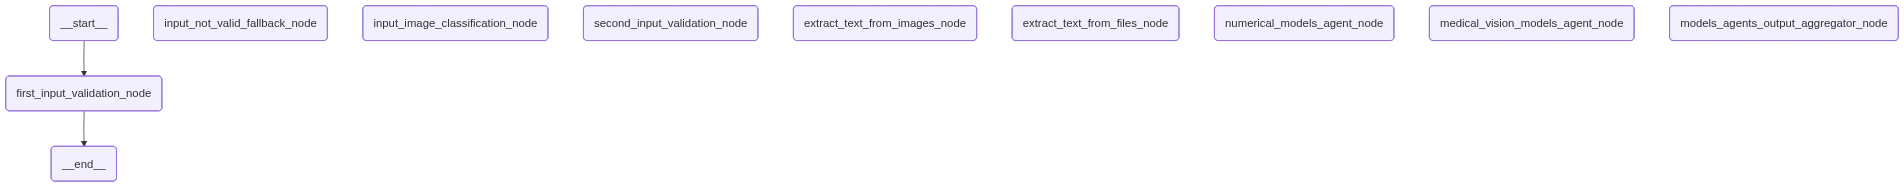

In [43]:
workflow.set_entry_point("first_input_validation_node")
app = workflow.compile()
app

# For visualization

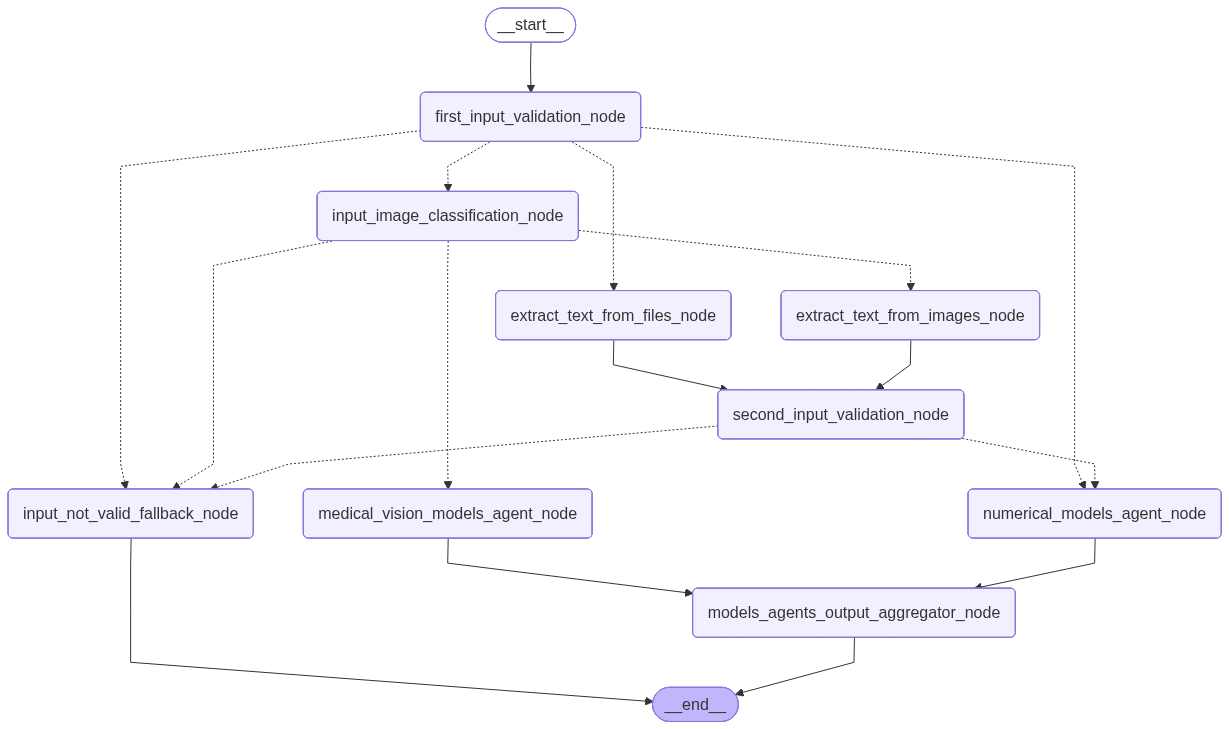

In [52]:
workflow.add_node("first_input_validation_node", first_input_validation_node)
workflow.add_node("input_not_valid_fallback_node", input_not_valid_fallback_node)
workflow.add_node("input_image_classification_node", input_image_classification_node)
workflow.add_node("second_input_validation_node", second_input_validation_node)
workflow.add_node("extract_text_from_images_node", extract_text_from_images_node)
workflow.add_node("extract_text_from_files_node", extract_text_from_files_node)
workflow.add_node("numerical_models_agent_node", numerical_models_agent_node)
workflow.add_node("medical_vision_models_agent_node", medical_vision_models_agent_node)
workflow.add_node("models_agents_output_aggregator_node", models_agents_output_aggregator_node)

workflow.add_edge("numerical_models_agent_node", "models_agents_output_aggregator_node")
workflow.add_edge("medical_vision_models_agent_node", "models_agents_output_aggregator_node")

workflow.add_edge("extract_text_from_images_node", "second_input_validation_node")
workflow.add_edge("extract_text_from_files_node", "second_input_validation_node")


workflow.add_conditional_edges(
    "first_input_validation_node", 
    input_splitter_route,
    {
        "input_not_valid_fallback_node": "input_not_valid_fallback_node",
        "extract_text_from_files_node": "extract_text_from_files_node",
        "input_image_classification_node": "input_image_classification_node",
        "numerical_models_agent_node": "numerical_models_agent_node"
    }
)

workflow.add_conditional_edges(
    "input_image_classification_node",
    input_image_classification_route,
    {
        "extract_text_from_images_node": "extract_text_from_images_node",
        "input_not_valid_fallback_node": "input_not_valid_fallback_node",
        "medical_vision_models_agent_node": "medical_vision_models_agent_node"
    }
)

workflow.add_conditional_edges(
    "second_input_validation_node",
    second_input_validation_route,
    {
        "input_not_valid_fallback_node": "input_not_valid_fallback_node",
        "numerical_models_agent_node": "numerical_models_agent_node"
    }
)

workflow.set_entry_point("first_input_validation_node")
app = workflow.compile()

app